In [1]:
from utils import *

import folium
import geopandas as gpd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

## Data description

In [2]:
macro_df = pd.read_csv('data/macro.csv', parse_dates=['timestamp'])
train_df = pd.read_csv('data/train.csv', index_col='id', parse_dates=['timestamp'])
test_df = pd.read_csv('data/test.csv', index_col='id', parse_dates=['timestamp'])
tverskoe_issue_fix(train_df)
tverskoe_issue_fix(test_df)

Fix:  550
Fix:  149


## 1. Data preprocessing
## I part (encoding and correcting mistakes)

### Macro dataset

In [3]:
macro_df['child_on_acc_pre_school'] = macro_df['child_on_acc_pre_school'].str.replace('#!', 'nan')
for column in macro_df.select_dtypes('object').columns:
    macro_df[column] = macro_df[column].str.replace(',', '.')
    macro_df[column] = macro_df[column].astype(float)

if not len(macro_df.select_dtypes('object').columns):
    print('OK')

OK


### Train dataset

In [4]:
train_df = encode(train_df)

### Test dataset

In [5]:
test_df = encode(test_df)

## II part (Filling missing values)

XGBRegressor model handles `np.NaN` values itself

## 2. Encoding `sub_area` feature

In [6]:
train_df['is_train'] = 1
test_df['is_train'] = 0

coords_df = pd.read_csv('data/coords.csv', index_col='id')
all_df = pd.concat([train_df, test_df])

all_df['latitude'] = coords_df['latitude']
all_df['longitude'] = coords_df['longitude']

## 3. Removing outliers

In [7]:
all_df = remove_outliers(all_df)

In [8]:
train_df = all_df[all_df['is_train'] == 1].drop(['is_train'], axis=1)
test_df = all_df[all_df['is_train'] == 0].drop(['is_train', 'price_doc'], axis=1)

In [9]:
X = train_df.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df['price_doc'])
X_test = test_df.drop(['sub_area'], axis=1).copy()

In [14]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.20378	validation_1-rmse:8.19001
[1]	validation_0-rmse:7.79567	validation_1-rmse:7.78230
[2]	validation_0-rmse:7.40813	validation_1-rmse:7.39491
[3]	validation_0-rmse:7.03993	validation_1-rmse:7.02689
[4]	validation_0-rmse:6.69021	validation_1-rmse:6.67740
[5]	validation_0-rmse:6.35818	validation_1-rmse:6.34557
[6]	validation_0-rmse:6.04272	validation_1-rmse:6.03043
[7]	validation_0-rmse:5.74310	validation_1-rmse:5.73103
[8]	validation_0-rmse:5.45855	validation_1-rmse:5.44680
[9]	validation_0-rmse:5.18833	validation_1-rmse:5.17683
[10]	validation_0-rmse:4.93174	validation_1-rmse:4.92050
[11]	validation_0-rmse:4.68805	validation_1-rmse:4.67695
[12]	validation_0-rmse:4.45669	validation_1-rmse:4.44585
[13]	validation_0-rmse:4.23700	validation_1-rmse:4.22634
[14]	validation_0-rmse:4.02843	validation_1-rmse:4.01804
[15]	validation_0-rmse:3.83046	validation_1-rmse:3.82018
[16]	validation_0-rmse:3.64249	validation_1-rmse:3.63241
[17]	validation_0-rmse:3.46406	validation

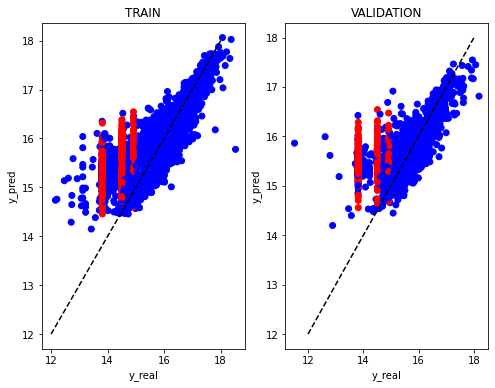

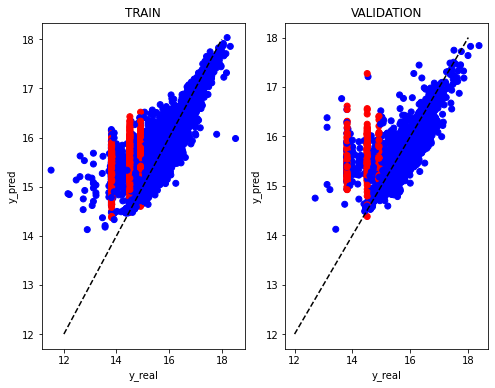

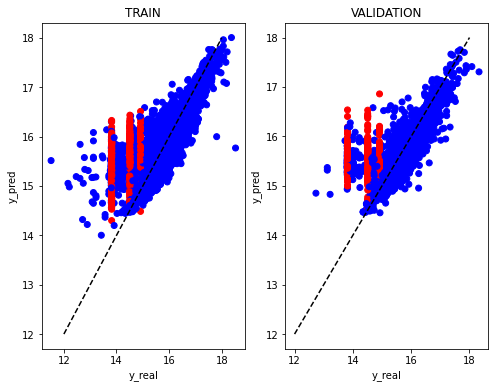

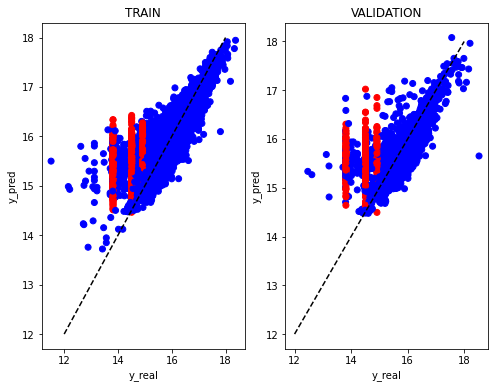

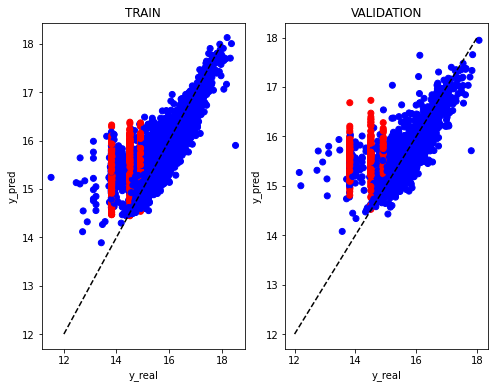

In [117]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

<AxesSubplot:>

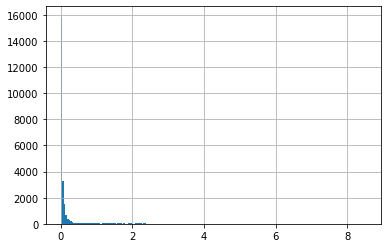

In [118]:
train_errors[0].hist(bins=200)

### `product_type == 'OwnerOccupier'`

In [107]:
train_df_1 = train_df[train_df['product_type'] == 1]
test_df_1 = test_df[test_df['product_type'] == 1]

X_1 = train_df_1.drop(['sub_area', 'price_doc'], axis=1).copy()
y_1 = np.log1p(train_df_1['price_doc'])
X_test_1 = test_df_1.drop(['sub_area'], axis=1).copy()

In [ ]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X_1)

params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X_1.iloc[train_index], X_1.iloc[val_index]
    y_train, y_val = y_1.iloc[train_index], y_1.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

In [ ]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X_1)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y_1.iloc[train_index], y_1.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

In [ ]:
train_errors[0].hist(bins=200)

### `product_type == 'Investment'`

In [ ]:
train_df_0 = train_df[train_df['product_type'] == 0]
test_df_0 = test_df[test_df['product_type'] == 0]

X_0 = train_df_0.drop(['sub_area', 'price_doc'], axis=1).copy()
y_0 = np.log1p(train_df_0['price_doc'])
X_test_0 = test_df_0.drop(['sub_area'], axis=1).copy()

In [ ]:
X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(X_0, y_0, test_size=0.2, random_state=42)
X_train_0.shape, X_val_0.shape

((13916, 293), (3480, 293))

In [ ]:
params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

model_0 = XGBRegressor(**params)

model_0.fit(X_train_0, y_train_0, eval_set=[(X_train_0, y_train_0), (X_val_0, y_val_0)], early_stopping_rounds=50)

[0]	validation_0-rmse:8.37687	validation_1-rmse:8.37489
[1]	validation_0-rmse:7.95922	validation_1-rmse:7.95715
[2]	validation_0-rmse:7.56252	validation_1-rmse:7.56037
[3]	validation_0-rmse:7.18565	validation_1-rmse:7.18344
[4]	validation_0-rmse:6.82765	validation_1-rmse:6.82541
[5]	validation_0-rmse:6.48762	validation_1-rmse:6.48532
[6]	validation_0-rmse:6.16458	validation_1-rmse:6.16226
[7]	validation_0-rmse:5.85775	validation_1-rmse:5.85541
[8]	validation_0-rmse:5.56629	validation_1-rmse:5.56392
[9]	validation_0-rmse:5.28945	validation_1-rmse:5.28706
[10]	validation_0-rmse:5.02649	validation_1-rmse:5.02402
[11]	validation_0-rmse:4.77673	validation_1-rmse:4.77407
[12]	validation_0-rmse:4.53950	validation_1-rmse:4.53680
[13]	validation_0-rmse:4.31417	validation_1-rmse:4.31153
[14]	validation_0-rmse:4.10015	validation_1-rmse:4.09753
[15]	validation_0-rmse:3.89689	validation_1-rmse:3.89423
[16]	validation_0-rmse:3.70383	validation_1-rmse:3.70120
[17]	validation_0-rmse:3.52049	validation

XGBRegressor(base_score=7, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eval_metric='rmse',
             gamma=0, gpu_id=0, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             nthread=-1, num_parallel_tree=1, random_state=42, reg_alpha=1,
             reg_lambda=5, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [ ]:
y_pred_train = np.abs(model_0.predict(X_train_0))
y_pred_val = np.abs(model_0.predict(X_val_0))
print('___________________________________')
print('      RMSLE\n')
print('      TRAIN_1:', np.sqrt(mean_squared_log_error(np.expm1(y_train_0), np.expm1(y_pred_train))))
print(' VALIDATION_1:', np.sqrt(mean_squared_log_error(np.expm1(y_val_0), np.expm1(y_pred_val))))
print('___________________________________')
print('      MAE\n')
print('      TRAIN_1:', mean_absolute_error(np.expm1(y_train_0), np.expm1(y_pred_train)))
print(' VALIDATION_1:', mean_absolute_error(np.expm1(y_val_0), np.expm1(y_pred_val)))

___________________________________
      RMSLE

      TRAIN_1: 0.2297278099989123
 VALIDATION_1: 0.28667372484083364
___________________________________
      MAE

      TRAIN_1: 953739.1728945102
 VALIDATION_1: 1220016.825


In [ ]:
test_df_nan = test_df[test_df['product_type'].isna()]
X_test_nan = test_df_nan.drop(['sub_area'], axis=1).copy()

In [ ]:
submission = pd.read_csv('data/sample_submission.csv', index_col='id')
pred_0 = np.expm1(model_0.predict(X_test_0))
pred_1 = np.expm1(model_1.predict(X_test_1))
pred_nan = np.expm1(model_1.predict(X_test_nan))

if len(pred_0[pred_0 < 0]) or len(pred_1[pred_1 < 0]) or len(pred_nan[pred_nan < 0]):
    print('WARNING: NEGATIVE PREDICTIONS')

In [ ]:
submission.loc[X_test_0.index, 'price_doc'] = 0.9*pred_0
submission.loc[X_test_1.index, 'price_doc'] = 0.93*pred_1
submission.loc[X_test_nan.index, 'price_doc'] = pred_nan
submission.to_csv('submits/submission.csv', index='id')

In [ ]:
!kaggle competitions submit -c sberbank-russian-housing-market -f "submits/submission.csv" -m "XGBRegressor tuned"

100%|████████████████████████████████████████| 121k/121k [00:03<00:00, 40.2kB/s]
Successfully submitted to Sberbank Russian Housing Market

In [ ]:
# !kaggle competitions submissions -c sberbank-russian-housing-market